# Bubble Shear Test Case

As outlined in McManus et al(2017)[1] Section 5.1, there is an advection problem with a time-dependent velocity field that is periodic. The equation we solve is the pure scalar advection equation 
$$
\frac{\partial u}{\partial t} + \nabla \cdot (\mathbf{c} u) = 0
$$

where $\mathbf{c}$ is defined as 
$$
c(x, y, t) = \begin{bmatrix}
2 \sin^2(\pi x) \sin(2\pi y) \cos (\frac{2\pi t}{T}) \\
-2\sin(2 \pi x) \sin^2(\pi y) \cos (\frac{2\pi t}{T}) \\
\end{bmatrix}
$$

At $t = 0$, $u = 0$ everywhere except in a ball (bubble) of radius $0.15$ centered in $(0.5, 0.8)$, which models a bubble and where u = 1. This bubble is sheared as per the advecting velocity field. 

In [1]:
from firedrake import *
from pyroteus import *
from pyroteus_adjoint import *
import matplotlib.pyplot as plt
from movement import *
%matplotlib inline
plt.rcParams['figure.facecolor'] = 'white'  # Ensure  background on plots is white

T = Constant(3.000)
B_RADIUS = 0.1
B_X = 0.5
B_Y = 0.8



def get_velocity(coords, t):
    x, y = coords
    return as_vector([
        2*sin(pi*x)*sin(pi*x)*sin(2*pi*y)*cos(2*pi*t/T),
        -2*sin(2*pi*x)*sin(pi*y)*sin(pi*y)*cos(2*pi*t/T)])
        

def get_form(mesh_seq):
    def form(index, solutions):
        u, u_ = solutions["u"]
        P = mesh_seq.time_partition
        t_start, t_end = P.subintervals[index]
        dt = Constant(P.timesteps[index])
        t = t_start + index * dt
        P1_vec = VectorFunctionSpace(u.function_space().mesh(), "CG", 1)
        c = Function(P1_vec, name="c")
        c.interpolate(get_velocity(SpatialCoordinate(P1_vec.mesh()), t))
        v = TestFunction(u.function_space())
#       TODO: Try integrating by parts
#       TODO: + diffusive term?
        F = (
            inner((u - u_) / dt, v) * dx
#             + inner(nabla_div(u * c), v) * dx
            + inner(dot(nabla_grad(u), c), v) * dx
            + inner(dot(u, nabla_div(c)), v) * dx
        )
        return F

    return form


def get_solver(mesh_seq):
    def solver(index, ic):
        function_space = mesh_seq.function_spaces["u"][index]
        u = Function(function_space)
        u_ = Function(function_space, name="u_old")
        u_.assign(ic["u"])
        
        
        P1_vec = VectorFunctionSpace(u.function_space().mesh(), "CG", 1)
        c = Function(P1_vec, name="c")
        
        # Define form
        F = mesh_seq.form(index, {"u": (u, u_), "c": (c, )})

        # Time integrate from start to end
        P = mesh_seq.time_partition
        t_start, t_end = P.subintervals[index]
        dt = P.timesteps[index]
        t = t_start
        while t < t_end - 1e-5:
            c.interpolate(get_velocity(SpatialCoordinate(P1_vec.mesh()), t))
            solve(F == 0, u, ad_block_tag="u")
            u_.assign(u)
            t += dt
        return {"u": u}

    return solver


def get_function_spaces(mesh):
    return {"u": FunctionSpace(mesh, "CG", 1),
            "c": VectorFunctionSpace(mesh, "CG", 1)}


def get_initial_condition(mesh_seq):
    fs = mesh_seq.function_spaces["u"][0]
    x, y = SpatialCoordinate(fs.mesh())
    c = conditional(le((x-B_X)**2 + (y-B_Y)**2, B_RADIUS**2), 1, 0)
    u = Function(fs, name='u_initial')
    u.interpolate(c)
    return {"u": u}


def get_qoi(mesh_seq, solutions, i):
    def end_time_qoi():
        u = solutions["u"]
        fs = u.function_space()
        x, y = SpatialCoordinate(fs.mesh())
        c = conditional(le((x-B_X)**2 + (y-B_Y)**2, B_RADIUS**2), 1, 0)
        ic = Function(fs)
        ic.interpolate(c)
        return inner((ic-u), (ic-u)) * dx

    
#     dt = Constant(mesh_seq.time_partition[i].timestep)
#     def time_integrated_qoi(t):
#         u = solutions["u"]
#         return dt * inner(u, u) * dx
        

    return end_time_qoi

firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


In [2]:
n_adapt = 0
adapt_tol = 1e-4
n = 64
fields = ["u"]
mesh = UnitSquareMesh(n, n, diagonal='left')
meshes = [mesh]
end_time = 1.500
dt = 0.015
num_subintervals = len(meshes)
timesteps_per_export = int(end_time / dt) / 10
print("Timesteps per export: {}".format(timesteps_per_export))
time_partition = TimePartition(
    end_time, num_subintervals, dt, fields, timesteps_per_export=timesteps_per_export,
)
mesh_seq = GoalOrientedMeshSeq(
    time_partition,
    meshes,
    get_function_spaces=get_function_spaces,
    get_initial_condition=get_initial_condition,
    get_form=get_form,
    get_solver=get_solver,
    get_qoi=get_qoi,
    qoi_type="end_time"
)

solutions, indicators = mesh_seq.indicate_errors(
    enrichment_kwargs={"enrichment_method": "p"}
)
print("QOI in forward solve: {:.5f}".format(mesh_seq.J))

Timesteps per export: 10.0
QOI in forward solve: 0.03043


10
10.0
2 5


Text(0.5, 1.0, 'Forward solution (0)')

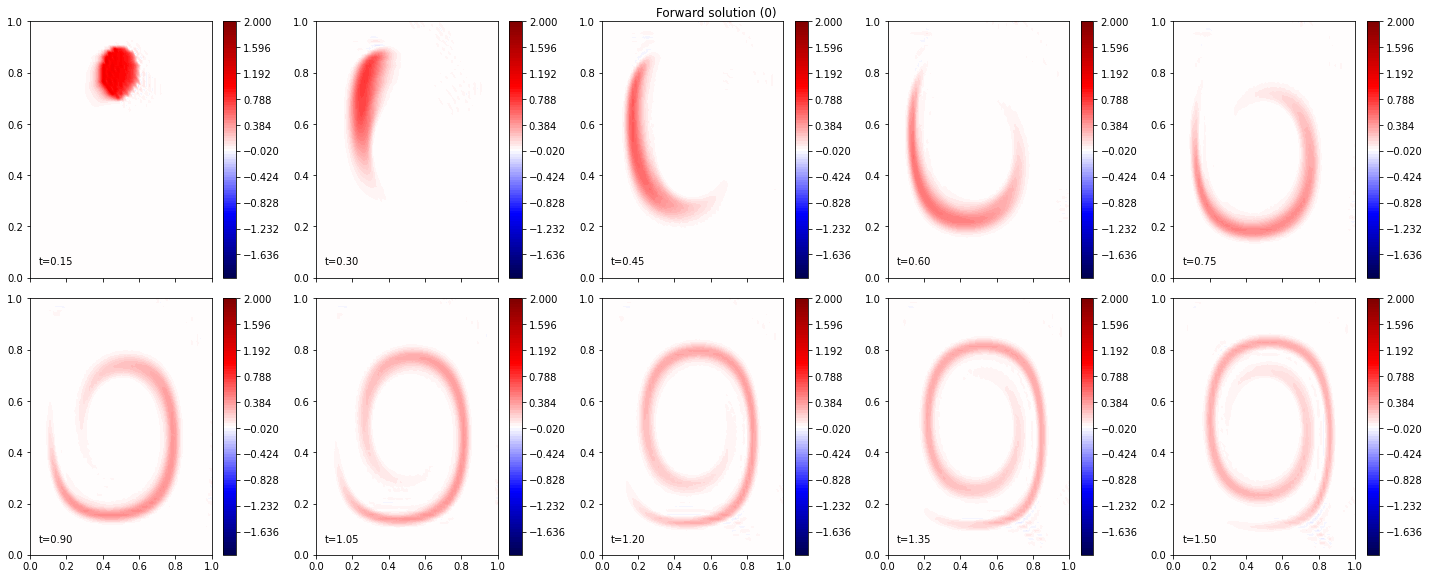

In [3]:
def plot_field(solutions, time_partition, field="u", label="forward", rows=None, cols=None, **kwargs):
    P = time_partition
    if rows is None or cols is None:
        rows = (P.exports_per_subinterval[0] - 1) // 2
        cols = (P.num_subintervals * 2)
    steady = rows == cols == 1
    print(rows, cols)
    dt = P.timesteps[0]
    figsize = kwargs.pop("figsize", (4 * cols, 4 * rows))
    fig, axes = plt.subplots(rows, cols, sharex="col", figsize=figsize)
    tcs = []
    idx = -1
    for i in range(rows):
        tc = []
        for j in range(cols):
            idx += 1
            ax = axes[i, j]
            # Element-wise norm for the indicators
            tc.append(tricontourf(solutions[field][label][0][idx], axes=ax, **kwargs))
            if not steady:
                time = (idx + 1) * dt * timesteps_per_export
                ax.annotate(f"t={time:.2f}", (0.05, 0.05), color="black")
            fig.colorbar(tc[-1], ax=ax)
        tcs.append(tc)
    plt.tight_layout()
    return fig, axes, tcs

print(len(solutions["u"]["forward"][0]))
# figsize = (5, 80)
steps = int(end_time / dt) / timesteps_per_export
print(steps)
rows, cols = 2, 5
vmin, vmax = -2, 2
fig, axes, tcs = plot_field(
    solutions, time_partition, "u", "forward", cmap='seismic',
    vmin=vmin, vmax=vmax, rows=rows, cols=cols, levels=np.linspace(vmin, vmax, 100))
# fig.tight_layout()
plt.suptitle("Forward solution ({})".format(n_adapt), ha='center', va='top', y=1.0)

2 5


Text(0.5, 1.0, 'Adjoint solution')

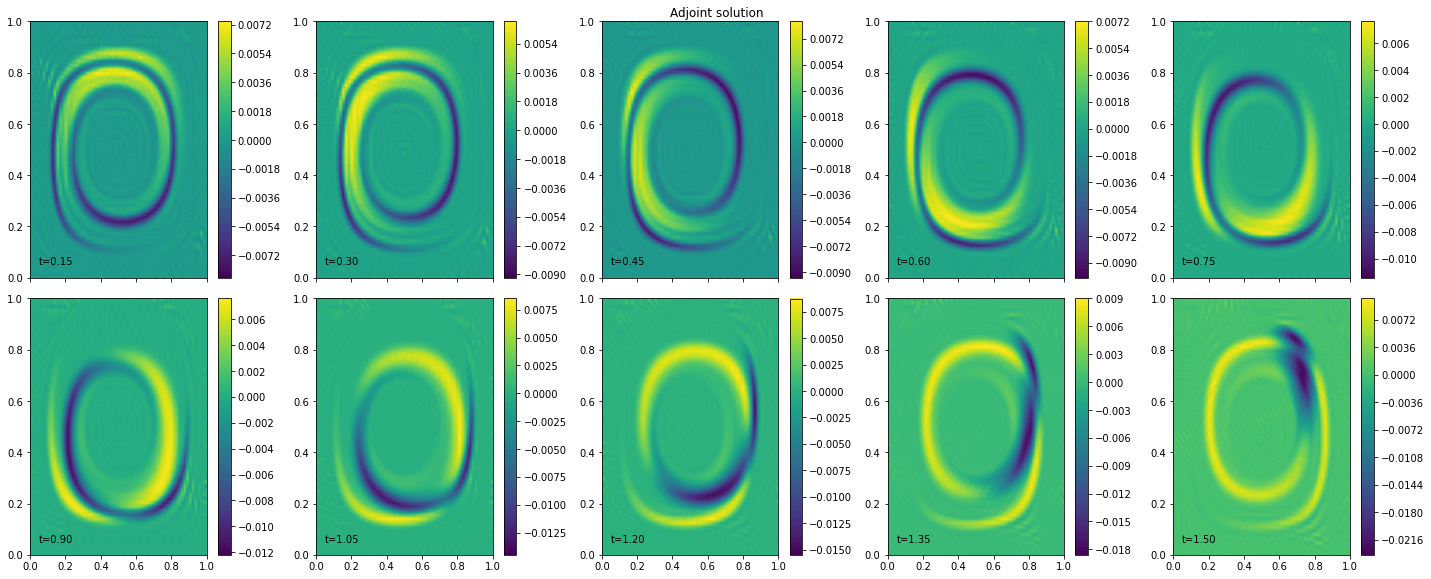

In [4]:
fig, axes, tcs = plot_field(
    solutions, time_partition, "u", "adjoint", cmap='viridis', rows=rows, cols=cols, levels=100)
plt.suptitle("Adjoint solution", ha='center', va='top', y=1.0)

Text(0.5, 1.0, 'DWR Indicators (0)')

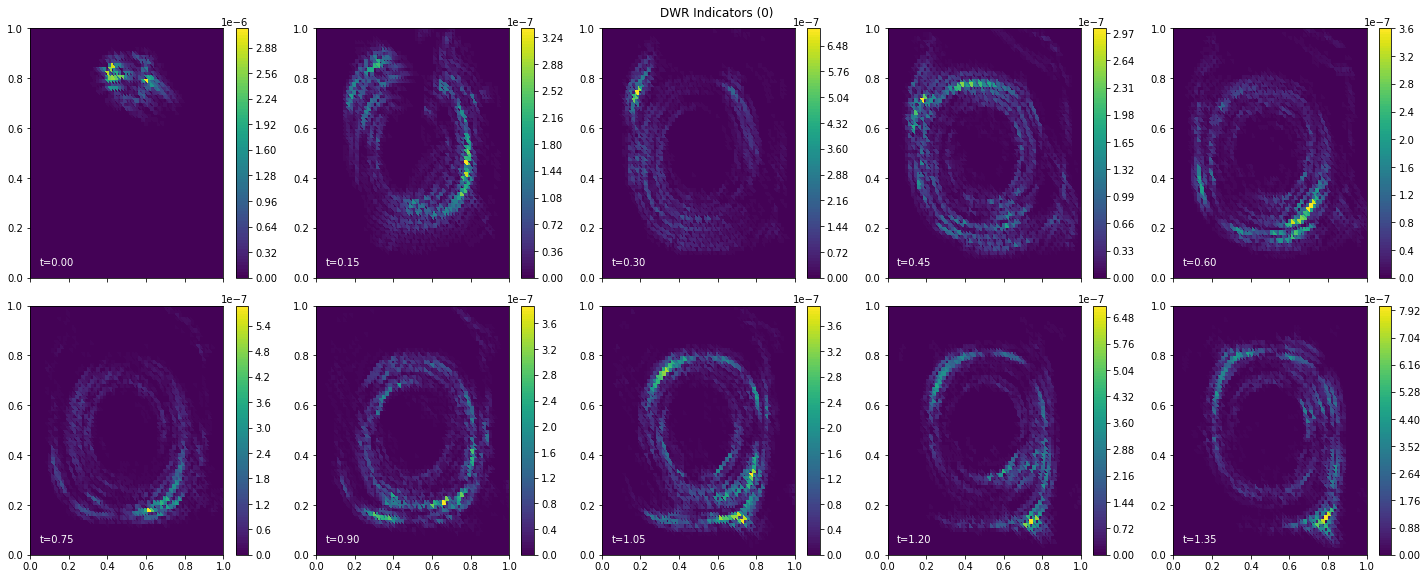

In [5]:
def plot_indicators(indicators, time_partition, **kwargs):
    P = time_partition
    rows = kwargs.pop('rows', (P.exports_per_subinterval[0] - 1) // 2)
    cols = kwargs.pop('cols', (P.num_subintervals * 2))
    steady = rows == cols == 1
#     print(rows, cols)
    dt = P.timesteps[0]
    figsize = kwargs.pop("figsize", (4 * cols, 4 * rows))
    fig, axes = plt.subplots(rows, cols, sharex="col", figsize=figsize)
    tcs = []
    idx = -1
    for i in range(rows):
        tc = []
        for j in range(cols):
            idx += 1
            ax = axes[i, j]
            # Element-wise norm for the indicators
            tc.append(tricontourf(indicators[0][idx], axes=ax, **kwargs))
            if not steady:
                time = idx * dt * timesteps_per_export
                ax.annotate(f"t={time:.2f}", (0.05, 0.05), color="white")
            fig.colorbar(tc[-1], ax=ax)
        tcs.append(tc)
    plt.tight_layout()
    return fig, axes, tcs

fig, axs, tcs = plot_indicators(indicators, time_partition, rows=rows, cols=cols, levels=100)
plt.suptitle("DWR Indicators ({})".format(n_adapt), ha='center', va='top', y=1.0)

## Define Monitor Function

Text(0.5, 1.0, 'Monitor Function (0)')

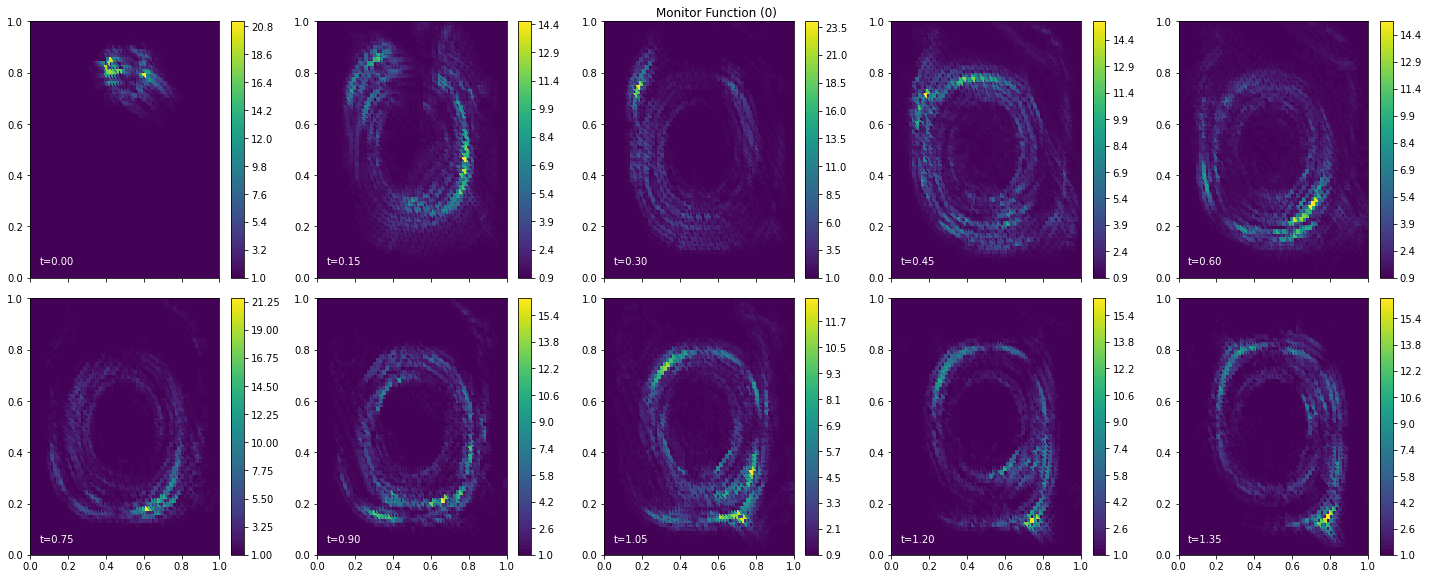

In [6]:
def standardize(arr):
    """
    Apply standardization based on mean and standard deviation
    """
    normed = (arr - np.mean(arr)) / np.std(arr)
    normed -= np.min(normed)
    normed += 1
    return normed

def lp_normalize(arr, p=2):
    """
    Normalize in L^p space.
    """
    retval = arr**p
    denom = sum(retval) ** (1 / p)
    retval /= denom
    return retval



p = 1
standardized_indicators = []
normalized_indicators = []
P0 = FunctionSpace(mesh_seq[0], "DG", 0)
for i in range(len(indicators)):
    t1 = []
    t2 = []
    for j in range(len(indicators[0])):
        t1.append(Function(P0, val=standardize(indicators[i][j].dat.data)))
        t2.append(Function(P0, val=lp_normalize(indicators[i][j].dat.data, p=p)))
    standardized_indicators.append(t1)
    normalized_indicators.append(t2)

fig, axs, tcs = plot_indicators(standardized_indicators, time_partition, rows=rows, cols=cols, levels=100)
plt.suptitle("Monitor Function ({})".format(n_adapt), ha='center', va='top', y=1.0)

In [7]:
import time
meshes = [UnitSquareMesh(n, n, diagonal='left') for i in range(len(indicators[0]))]
num_subintervals = len(meshes)
time_partition = TimePartition(
    end_time, num_subintervals, dt, fields, timesteps_per_export=1
)
def get_get_monitor(mesh, i, indicators):
    def get_monitor(mesh):
        P0 = FunctionSpace(mesh, "DG", 0)
        f = Function(P0)
        f.project(indicators[0][i])
        return f
    return get_monitor
start = time.time()
lap = start
for i, mesh in enumerate(meshes):
    print("Starting on mesh {}".format(i))
    get_mon = get_get_monitor(mesh, i, standardized_indicators)
    mover = MongeAmpereMover(mesh, get_mon, method="quasi_newton", maxiter=100, rtol=adapt_tol)
    mover.move();
    print("Took: {:.4f}s".format(time.time() - lap))
    lap = time.time()
n_adapt += 1
print("Overall took {:.4f}s".format(time.time() - start))

Starting on mesh 0
   0   Min/Max 6.9965e-02   Residual 6.3463e-01   Equidistribution 9.9826e-01
   1   Min/Max 8.8909e-02   Residual 4.4445e-01   Equidistribution 9.9891e-01
   2   Min/Max 6.3279e-02   Residual 3.2408e-01   Equidistribution 9.9929e-01
   3   Min/Max 1.2486e-01   Residual 2.3721e-01   Equidistribution 9.9939e-01
   4   Min/Max 1.2300e-01   Residual 1.8487e-01   Equidistribution 9.9944e-01
   5   Min/Max 1.8656e-01   Residual 1.3233e-01   Equidistribution 9.9952e-01
   6   Min/Max 1.4375e-01   Residual 8.4819e-02   Equidistribution 9.9962e-01
   7   Min/Max 2.8514e-01   Residual 5.1036e-02   Equidistribution 9.9972e-01
   8   Min/Max 2.7403e-01   Residual 3.0259e-02   Equidistribution 9.9973e-01
   9   Min/Max 3.0278e-01   Residual 1.8712e-02   Equidistribution 9.9973e-01
  10   Min/Max 3.1624e-01   Residual 1.2150e-02   Equidistribution 9.9974e-01
  11   Min/Max 3.1858e-01   Residual 6.9725e-03   Equidistribution 9.9974e-01
  12   Min/Max 3.2096e-01   Residual 4.5588e-

   2   Min/Max 1.4098e-01   Residual 2.4648e-01   Equidistribution 9.9945e-01
   3   Min/Max 1.9689e-01   Residual 1.4646e-01   Equidistribution 9.9954e-01
   4   Min/Max 2.1937e-01   Residual 9.5784e-02   Equidistribution 9.9957e-01
   5   Min/Max 2.7244e-01   Residual 6.2211e-02   Equidistribution 9.9964e-01
   6   Min/Max 4.1596e-01   Residual 3.5551e-02   Equidistribution 9.9972e-01
   7   Min/Max 4.7847e-01   Residual 2.2244e-02   Equidistribution 9.9974e-01
   8   Min/Max 4.7232e-01   Residual 1.4683e-02   Equidistribution 9.9975e-01
   9   Min/Max 5.0705e-01   Residual 8.2268e-03   Equidistribution 9.9976e-01
  10   Min/Max 5.1329e-01   Residual 5.3536e-03   Equidistribution 9.9976e-01
  11   Min/Max 5.1843e-01   Residual 3.9182e-03   Equidistribution 9.9976e-01
Converged in 11 iterations.
Took: 43.8537s
Starting on mesh 9
   0   Min/Max 9.5144e-02   Residual 5.6111e-01   Equidistribution 9.9872e-01
   1   Min/Max 1.1626e-01   Residual 3.4998e-01   Equidistribution 9.9930e-01
  

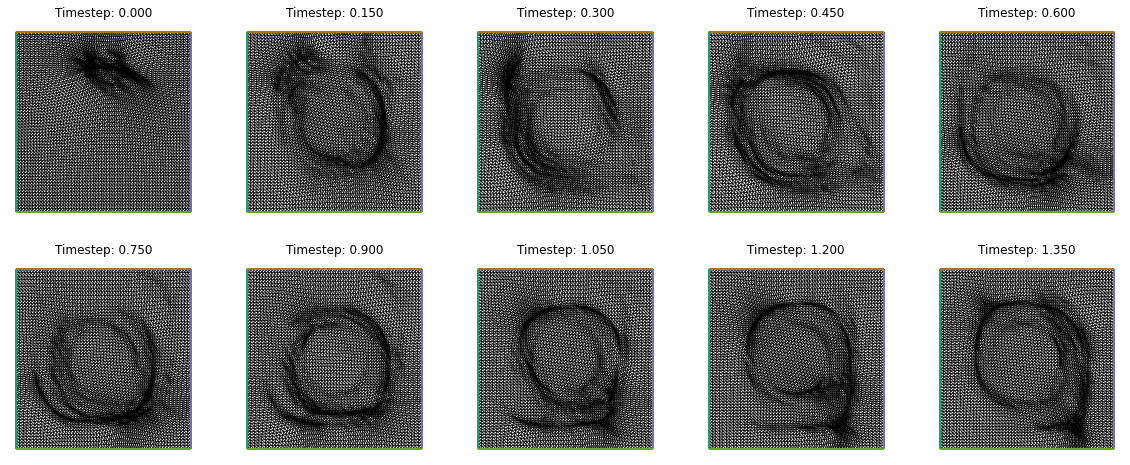

In [8]:
def plot_mesh(mesh, fig=None, axes=None, time_partition=None, **kwargs):
    kwargs.setdefault("interior_kw", {"linewidth": 0.5})
    kwargs.setdefault("boundary_kw", {"linewidth": 2.0})
    if fig is None and axes is None:
        fig, axes = plt.subplots(figsize=(5, 5))
    tp = triplot(mesh, axes=axes, **kwargs)
    axes.axis(False)
    return fig, axes, tp


fig, axs = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
tps = []
tp = []
for i in range(len(meshes)):
    row, col = i // (len(meshes) // rows), i % cols
    _, _, plot = plot_mesh(meshes[i], fig=fig, axes=axs[row, col])
    tp.append(plot)
    if time_partition is not None:
        time = i * dt * timesteps_per_export
        axs[row, col].set_title("Timestep: {:.3f}".format(time))
tps.append(tp)
# fig.tight_layout(pad=0.5)
# plt.suptitle("Adapted meshes")

In [9]:
print("Computing quality metrics")
quality_measures = {}
for i, mesh in enumerate(meshes):
    quality_measures[i] = {}
    quality_measures[i]["min_angle"] = get_min_angles2d(mesh)
    quality_measures[i]["aspect_ratio"] = get_aspect_ratios2d(mesh)
    quality_measures[i]["skewness"] = get_skewnesses2d(mesh)
    quality_measures[i]["scaled_jac"] = get_scaled_jacobians2d(mesh)
    print("Mesh {}".format(i))
#     print("Metric\t\tMin\t\tMax")
    for key in quality_measures[i].keys():
        print(
            "{}\t\t\t{:.3f}\t\t\t{:.3f}".format(
                key,
                np.min(quality_measures[i][key].dat.data),
                np.max(quality_measures[i][key].dat.data),
            )
        )
for key in quality_measures[0].keys():
    out_file = File(f"quality_measures_1/{key}.pvd")
    for i in range(len(meshes)):
        out_file.write(quality_measures[i][key])
    print("Wrote to {}".format(out_file))

Computing quality metrics
Mesh 0
min_angle			0.152			1.044
aspect_ratio			1.000			7.200
skewness			0.005			1.283
scaled_jac			0.152			0.865
Mesh 1
min_angle			0.181			1.031
aspect_ratio			1.000			7.372
skewness			0.021			1.279
scaled_jac			0.180			0.858
Mesh 2
min_angle			0.195			1.029
aspect_ratio			1.000			6.655
skewness			0.021			1.249
scaled_jac			0.194			0.857
Mesh 3
min_angle			0.228			1.014
aspect_ratio			1.001			5.181
skewness			0.033			1.192
scaled_jac			0.226			0.849
Mesh 4
min_angle			0.197			1.034
aspect_ratio			1.000			6.093
skewness			0.019			1.266
scaled_jac			0.195			0.859
Mesh 5
min_angle			0.203			1.041
aspect_ratio			1.000			5.564
skewness			0.011			1.201
scaled_jac			0.202			0.863
Mesh 6
min_angle			0.191			1.039
aspect_ratio			1.000			6.012
skewness			0.009			1.238
scaled_jac			0.190			0.862
Mesh 7
min_angle			0.245			1.013
aspect_ratio			1.001			6.148
skewness			0.036			1.221
scaled_jac			0.242			0.848
Mesh 8
min_angle			0.229			1.042
aspect_ratio			1.000			3.813


## Re-computing the forward, adjoint, QOI, and Monitor Function

In [10]:
mesh_seq = GoalOrientedMeshSeq(
    time_partition,
    meshes,
    get_function_spaces=get_function_spaces,
    get_initial_condition=get_initial_condition,
    get_form=get_form,
    get_solver=get_solver,
    get_qoi=get_qoi,
    qoi_type="end_time",
)
solutions, indicators = mesh_seq.indicate_errors(
    enrichment_kwargs={"enrichment_method": "p"}
)
print("New QOI: {:.5f}".format(mesh_seq.J))

New QOI: 0.01735


2 5


Text(0.5, 1.0, 'Forward solution (1)')

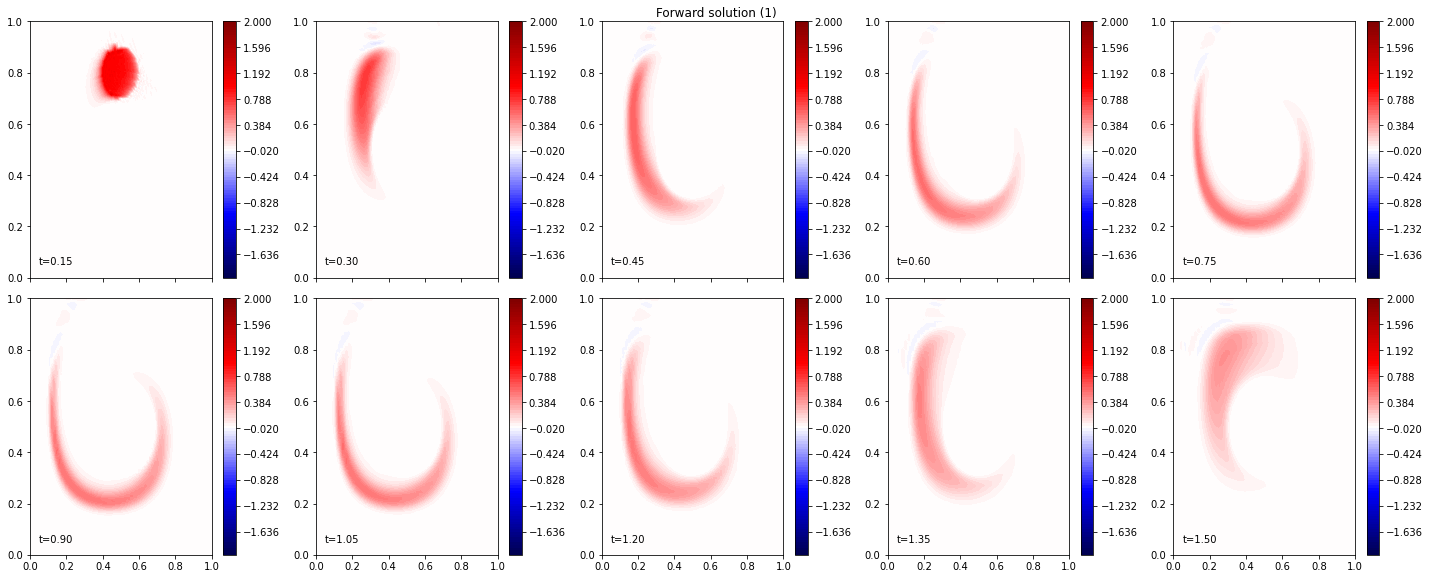

In [11]:
# print("New QOI: {:.5f}".format(mesh_seq.J))
def plot_field2(solutions, time_partition, field="u", label="forward", rows=None, cols=None, **kwargs):
    P = time_partition
    if rows is None or cols is None:
        rows = (P.exports_per_subinterval[0] - 1) // 2
        cols = (P.num_subintervals * 2)
    steady = rows == cols == 1
    print(rows, cols)
    dt = P.timesteps[0]
    figsize = kwargs.pop("figsize", (4 * cols, 4 * rows))
    fig, axes = plt.subplots(rows, cols, sharex="col", figsize=figsize)
    tcs = []
    idx = -1
    for i in range(rows):
        tc = []
        for j in range(cols):
            idx += 1
            ax = axes[i, j]
            # Element-wise norm for the indicators
            tc.append(tricontourf(solutions[field][label][idx][0], axes=ax, **kwargs))
            if not steady:
                time = (idx+1) * dt * timesteps_per_export
                ax.annotate(f"t={time:.2f}", (0.05, 0.05), color="black")
            fig.colorbar(tc[-1], ax=ax)
        tcs.append(tc)
    plt.tight_layout()
    return fig, axes, tcs

fig, axes, tcs = plot_field2(
    solutions, time_partition, "u", "forward", cmap='seismic',
    vmin=vmin, vmax=vmax, rows=rows, cols=cols, levels=np.linspace(vmin, vmax, 100))
plt.suptitle("Forward solution ({})".format(n_adapt), ha='center', va='top', y=1.0)

2 5


Text(0.5, 1.0, 'Adjoint solution (1)')

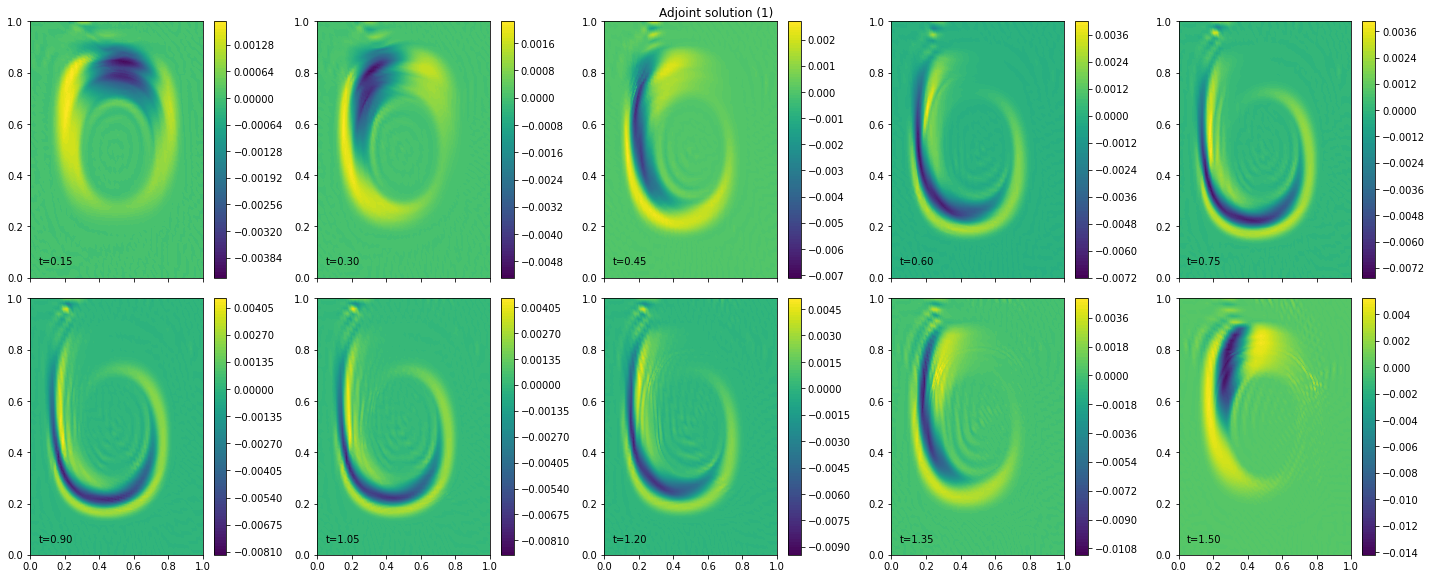

In [12]:
fig, axes, tcs = plot_field2(
    solutions, time_partition, "u", "adjoint", cmap='viridis', rows=rows, cols=cols, levels=100)
plt.suptitle("Adjoint solution ({})".format(n_adapt), ha='center', va='top', y=1.0)

In [13]:
# Just need this to go from 1 mesh 10 exports to 10 meshes 1 export each
def reorder_indicators(indicators):
    temp = [k[0] for k in indicators]
    temp_indicators = [temp]
    return temp_indicators

Text(0.5, 1.0, 'Monitor Function (1)')

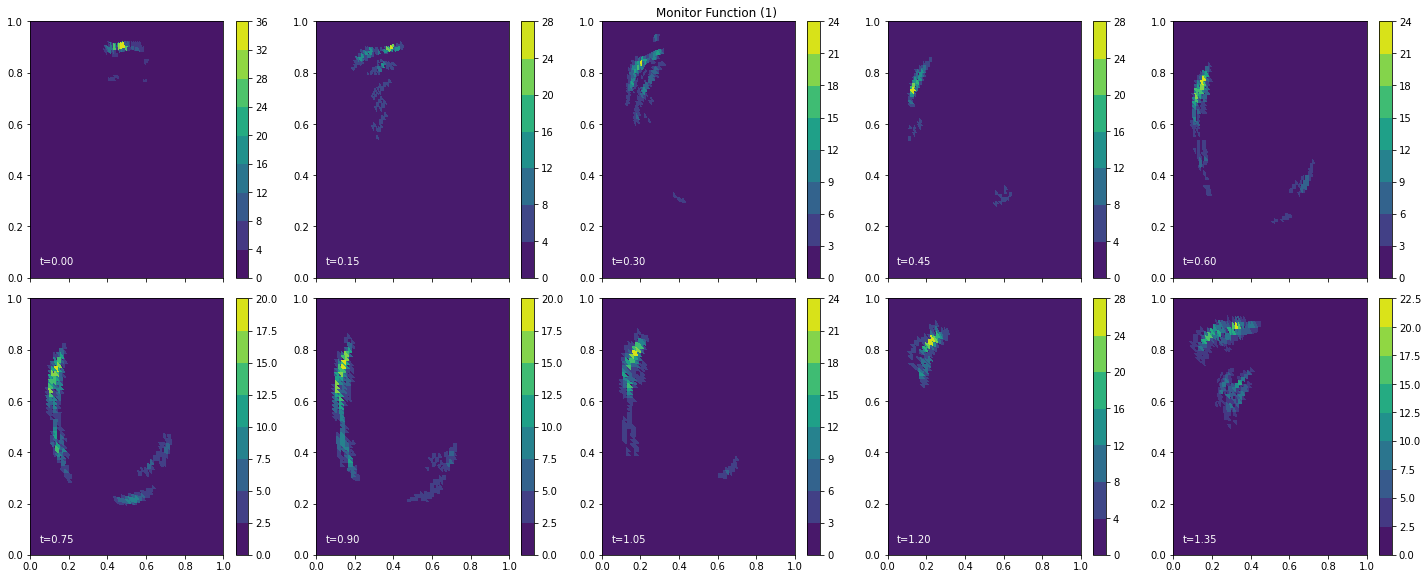

In [14]:
t_indicators = reorder_indicators(indicators)
standardized_indicators = []
for i in range(len(t_indicators)):
    t1 = []
    t2 = []
    for j in range(len(t_indicators[0])):
        P0 = FunctionSpace(mesh_seq[j], "DG", 0)
        t1.append(Function(P0, val=standardize(t_indicators[i][j].dat.data)))
    standardized_indicators.append(t1)

fig, axs, tcs = plot_indicators(standardized_indicators, time_partition, rows=rows, cols=cols)
plt.suptitle("Monitor Function ({})".format(n_adapt), ha='center', va='top', y=1.0)

In [15]:
import time
start = time.time()
lap = start
for i, mesh in enumerate(meshes):
    print("Starting on mesh {}".format(i))
    get_mon = get_get_monitor(mesh, i, standardized_indicators)
    mover = MongeAmpereMover(mesh, get_mon, method="quasi_newton", maxiter=100, rtol=adapt_tol)
    mover.move();
    print("Took: {:.4f}s".format(time.time() - lap))
    lap = time.time()
print("Overall took {:.4f}s".format(time.time() - start))
n_adapt += 1

print("Computing quality metrics")
quality_measures = {}
for i, mesh in enumerate(meshes):
    quality_measures[i] = {}
    quality_measures[i]["min_angle"] = get_min_angles2d(mesh)
    quality_measures[i]["aspect_ratio"] = get_aspect_ratios2d(mesh)
    quality_measures[i]["skewness"] = get_skewnesses2d(mesh)
    quality_measures[i]["scaled_jac"] = get_scaled_jacobians2d(mesh)
    print("Mesh {}".format(i))
#     print("Metric\t\tMin\t\tMax")
    for key in quality_measures[i].keys():
        print(
            "{}\t\t\t{:.3f}\t\t\t{:.3f}".format(
                key,
                np.min(quality_measures[i][key].dat.data),
                np.max(quality_measures[i][key].dat.data),
            )
        )
for key in quality_measures[0].keys():
    out_file = File(f"quality_measures_2/{key}.pvd")
    for i in range(len(meshes)):
        out_file.write(quality_measures[i][key])
    print("Wrote to {}".format(out_file))

Starting on mesh 0
   0   Min/Max 4.0476e-02   Residual 5.1674e-01   Equidistribution 9.9699e-01
   1   Min/Max 6.4146e-02   Residual 1.1474e-01   Equidistribution 9.9900e-01
   2   Min/Max 1.7082e-04   Residual 1.6658e-02   Equidistribution 9.9944e-01
   3   Min/Max 3.9645e-04   Residual 1.4733e-03   Equidistribution 9.9952e-01
Converged in 3 iterations.
Took: 1.4604s
Starting on mesh 1
   0   Min/Max 6.1123e-02   Residual 4.0904e-01   Equidistribution 9.9800e-01
   1   Min/Max 1.5051e-01   Residual 8.0856e-02   Equidistribution 9.9943e-01
   2   Min/Max 6.9240e-02   Residual 7.8900e-03   Equidistribution 9.9965e-01
   3   Min/Max 2.9826e-02   Residual 1.8471e-04   Equidistribution 9.9966e-01
Converged in 3 iterations.
Took: 1.5865s
Starting on mesh 2
   0   Min/Max 7.8388e-02   Residual 4.0140e-01   Equidistribution 9.9844e-01
   1   Min/Max 1.1181e-01   Residual 7.2264e-02   Equidistribution 9.9948e-01
   2   Min/Max 1.4667e-03   Residual 6.3924e-03   Equidistribution 9.9966e-01
   

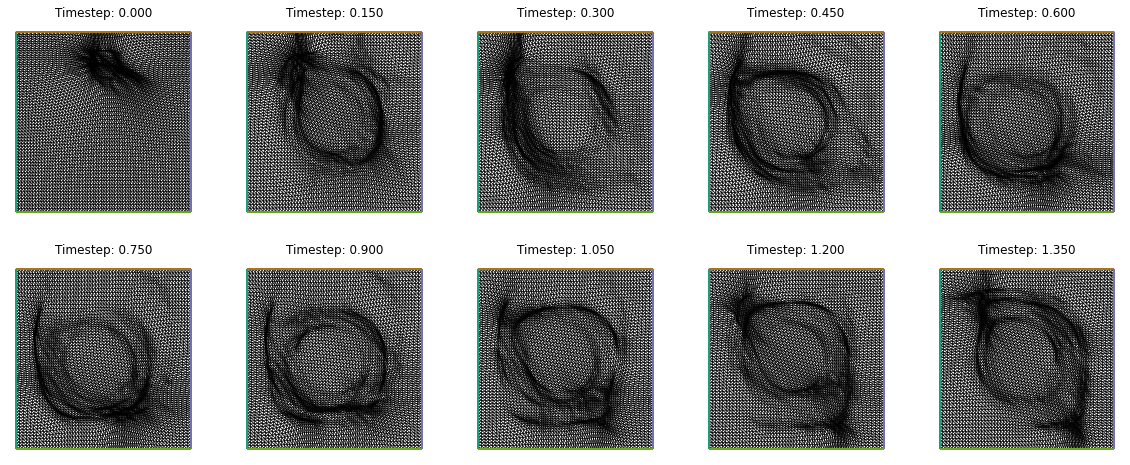

In [16]:
fig, axs = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
tps = []
tp = []
for i in range(len(meshes)):
    row, col = i // (len(meshes) // rows), i % cols
    _, _, plot = plot_mesh(meshes[i], fig=fig, axes=axs[row, col])
    tp.append(plot)
    if time_partition is not None:
        time = i * dt * timesteps_per_export
        axs[row, col].set_title("Timestep: {:.3f}".format(time))
tps.append(tp)

New QOI: 0.01681
2 5


Text(0.5, 1.0, 'Forward solution after adapt (2)')

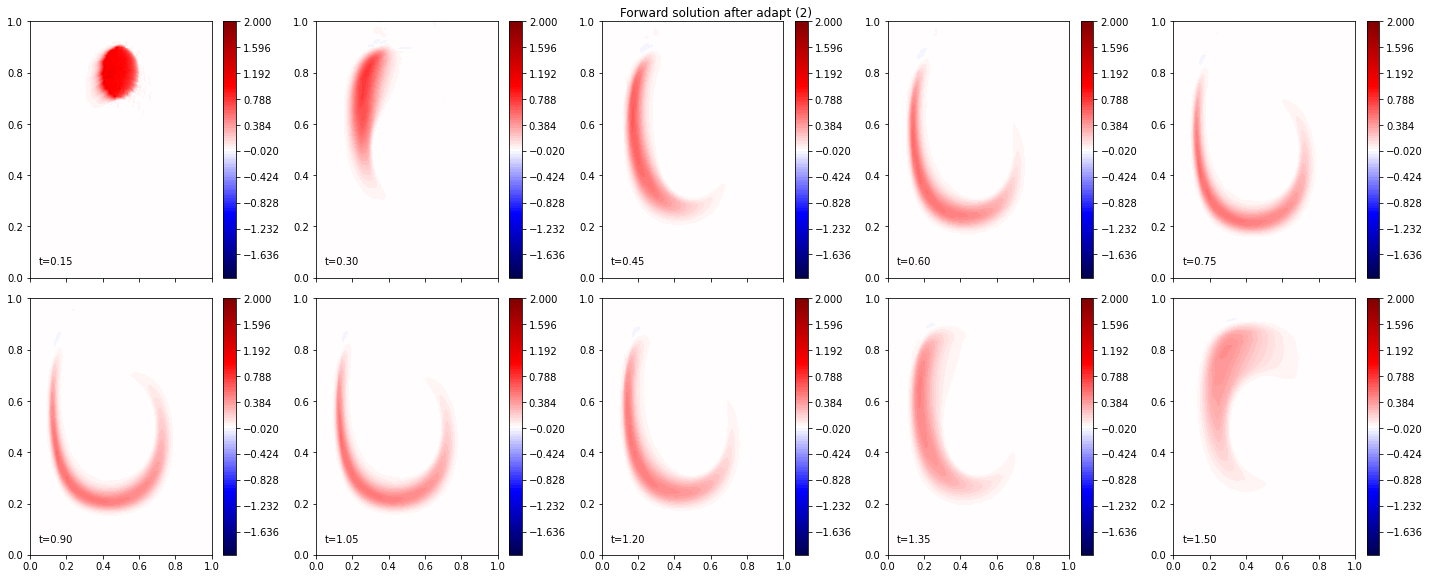

In [17]:
mesh_seq = GoalOrientedMeshSeq(
    time_partition,
    meshes,
    get_function_spaces=get_function_spaces,
    get_initial_condition=get_initial_condition,
    get_form=get_form,
    get_solver=get_solver,
    get_qoi=get_qoi,
    qoi_type="end_time",
)
solutions, indicators = mesh_seq.indicate_errors(
    enrichment_kwargs={"enrichment_method": "p"}
)
print("New QOI: {:.5f}".format(mesh_seq.J))

fig, axes, tcs = plot_field2(
    solutions, time_partition, "u", "forward", cmap='seismic',
    vmin=vmin, vmax=vmax, rows=rows, cols=cols, levels=np.linspace(vmin, vmax, 100))
plt.suptitle("Forward solution after adapt ({})".format(n_adapt), ha='center', va='top', y=1.0)

Text(0.5, 1.0, 'Monitor Function (2)')

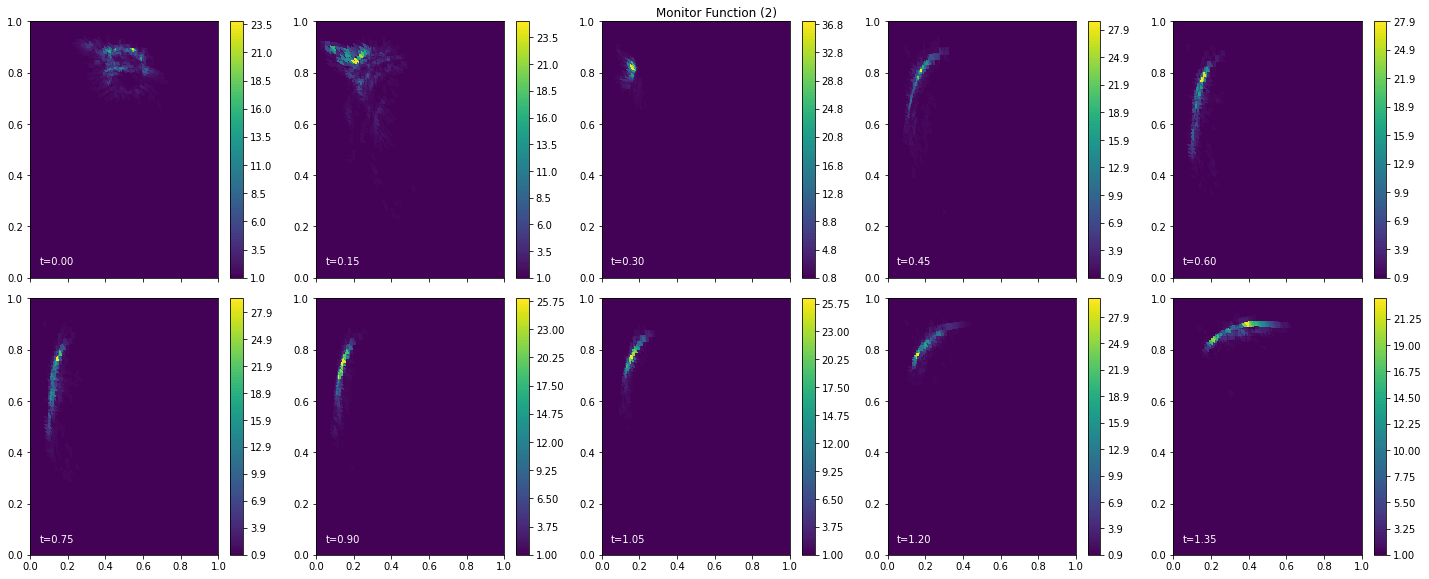

In [18]:
t_indicators = reorder_indicators(indicators)
standardized_indicators = []
for i in range(len(t_indicators)):
    t1 = []
    t2 = []
    for j in range(len(t_indicators[0])):
        P0 = FunctionSpace(mesh_seq[j], "DG", 0)
        t1.append(Function(P0, val=standardize(t_indicators[i][j].dat.data)))
    standardized_indicators.append(t1)

fig, axs, tcs = plot_indicators(standardized_indicators, time_partition, rows=rows, cols=cols, levels=100)
plt.suptitle("Monitor Function ({})".format(n_adapt), ha='center', va='top', y=1.0)

In [20]:
import time
start = time.time()
lap = start
for i, mesh in enumerate(meshes):
    print("Starting on mesh {}".format(i))
    get_mon = get_get_monitor(mesh, i, standardized_indicators)
    mover = MongeAmpereMover(mesh, get_mon, method="quasi_newton", maxiter=1000, rtol=adapt_tol)
    mover.move();
    print("Took: {:.4f}s".format(time.time() - lap))
    lap = time.time()
print("Overall took {:.4f}s".format(time.time() - start))

Starting on mesh 0
   0   Min/Max 8.5793e-02   Residual 2.0833e-01   Equidistribution 9.9858e-01
   1   Min/Max 1.4518e-05   Residual 3.7375e-02   Equidistribution 5.0265e+00
   2   Min/Max 2.2570e-07   Residual 1.4466e+00   Equidistribution 6.7540e+02
   3   Min/Max 6.3335e-07   Residual 3.9250e-01   Equidistribution 1.7204e+01
   4   Min/Max 5.6481e-07   Residual 1.1584e-01   Equidistribution 4.4993e+00
   5   Min/Max 3.0617e-06   Residual 9.2143e-02   Equidistribution 1.7666e+00
   6   Min/Max 1.8401e-07   Residual 8.7380e-02   Equidistribution 2.9179e+01
   7   Min/Max 4.7835e-08   Residual 2.9735e-02   Equidistribution 3.1454e+01
   8   Min/Max 2.0078e-07   Residual 6.8288e+00   Equidistribution 3.2354e+02
   9   Min/Max 5.3597e-07   Residual 1.9482e+00   Equidistribution 1.7979e+02
  10   Min/Max 9.4603e-08   Residual 5.0378e-01   Equidistribution 2.6447e+02
  11   Min/Max 5.3445e-08   Residual 3.3586e-01   Equidistribution 2.0289e+02
  12   Min/Max 7.2803e-07   Residual 1.0735e-

SystemError: <built-in method insert of list object at 0x7f4bf209e1c8> returned a result with an error set

Exception ignored in: 'petsc4py.PETSc.traceback'
SystemError: <built-in method insert of list object at 0x7f4bf209e1c8> returned a result with an error set


  46   Min/Max 2.1576e-06   Residual 1.4681e-01   Equidistribution 1.1990e+01
  47   Min/Max 1.3830e-06   Residual 4.9432e-02   Equidistribution 4.0176e+01
  48   Min/Max 1.3399e-06   Residual 2.6967e-02   Equidistribution 4.2806e+01
  49   Min/Max 7.1887e-07   Residual 6.0803e-01   Equidistribution 3.8887e+01
  50   Min/Max 7.5929e-08   Residual 2.7018e-01   Equidistribution 2.5317e+01
  51   Min/Max 9.7763e-07   Residual 7.5475e-02   Equidistribution 1.3679e+01
  52   Min/Max 4.6563e-07   Residual 6.9107e-02   Equidistribution 2.2114e+01
  53   Min/Max 3.6509e-07   Residual 5.3093e-02   Equidistribution 2.7126e+01
  54   Min/Max 4.1558e-07   Residual 5.3879e-02   Equidistribution 2.7511e+01
  55   Min/Max 5.9860e-07   Residual 4.7282e-02   Equidistribution 3.2176e+01
  56   Min/Max 6.5606e-07   Residual 4.9622e-02   Equidistribution 3.0499e+01
  57   Min/Max 2.3295e-07   Residual 4.3420e-02   Equidistribution 3.6367e+01
  58   Min/Max 2.9595e-07   Residual 7.4073e-01   Equidistributi

  58   Min/Max 4.3664e-05   Residual 1.7170e-01   Equidistribution 9.7862e-01
  59   Min/Max 4.9049e-05   Residual 1.6973e-01   Equidistribution 9.8083e-01
  60   Min/Max 6.4363e-05   Residual 1.6722e-01   Equidistribution 9.8528e-01
  61   Min/Max 5.7725e-05   Residual 1.6800e-01   Equidistribution 9.8362e-01
  62   Min/Max 5.2030e-05   Residual 1.6900e-01   Equidistribution 9.8189e-01
  63   Min/Max 4.0849e-05   Residual 1.7327e-01   Equidistribution 9.7727e-01
  64   Min/Max 4.6019e-05   Residual 1.7071e-01   Equidistribution 9.7964e-01
  65   Min/Max 5.2501e-05   Residual 1.6890e-01   Equidistribution 9.8204e-01
  66   Min/Max 3.8705e-05   Residual 1.7489e-01   Equidistribution 9.7615e-01
  67   Min/Max 4.3988e-05   Residual 1.7155e-01   Equidistribution 9.7876e-01
  68   Min/Max 4.9447e-05   Residual 1.6962e-01   Equidistribution 9.8097e-01
  69   Min/Max 6.9020e-05   Residual 1.6683e-01   Equidistribution 9.8626e-01
  70   Min/Max 6.0951e-05   Residual 1.6758e-01   Equidistributi

 164   Min/Max 4.4322e-05   Residual 1.7134e-01   Equidistribution 9.7896e-01
 165   Min/Max 4.9905e-05   Residual 1.6946e-01   Equidistribution 9.8119e-01
 166   Min/Max 8.4743e-05   Residual 1.6597e-01   Equidistribution 9.8883e-01
 167   Min/Max 7.0110e-05   Residual 1.6674e-01   Equidistribution 9.8651e-01
 168   Min/Max 6.1611e-05   Residual 1.6749e-01   Equidistribution 9.8468e-01
 169   Min/Max 5.5592e-05   Residual 1.6830e-01   Equidistribution 9.8306e-01
 170   Min/Max 4.9393e-05   Residual 1.6960e-01   Equidistribution 9.8101e-01
 171   Min/Max 7.0431e-05   Residual 1.6671e-01   Equidistribution 9.8657e-01
 172   Min/Max 6.1815e-05   Residual 1.6746e-01   Equidistribution 9.8473e-01
 173   Min/Max 5.5755e-05   Residual 1.6827e-01   Equidistribution 9.8311e-01
 174   Min/Max 4.9639e-05   Residual 1.6953e-01   Equidistribution 9.8110e-01
 175   Min/Max 7.5922e-05   Residual 1.6638e-01   Equidistribution 9.8754e-01
 176   Min/Max 6.5176e-05   Residual 1.6713e-01   Equidistributi

 270   Min/Max 9.1200e-05   Residual 1.6877e-01   Equidistribution 9.8230e-01
 271   Min/Max 8.5727e-05   Residual 1.6950e-01   Equidistribution 9.8126e-01
 272   Min/Max 1.0255e-04   Residual 1.6768e-01   Equidistribution 9.8414e-01
 273   Min/Max 9.6417e-05   Residual 1.6821e-01   Equidistribution 9.8319e-01
 274   Min/Max 9.1576e-05   Residual 1.6872e-01   Equidistribution 9.8236e-01
 275   Min/Max 8.6316e-05   Residual 1.6941e-01   Equidistribution 9.8138e-01
 276   Min/Max 1.1511e-04   Residual 1.6689e-01   Equidistribution 9.8578e-01
 277   Min/Max 1.0499e-04   Residual 1.6751e-01   Equidistribution 9.8448e-01
 278   Min/Max 9.8186e-05   Residual 1.6805e-01   Equidistribution 9.8347e-01
 279   Min/Max 9.3069e-05   Residual 1.6856e-01   Equidistribution 9.8262e-01
 280   Min/Max 8.8268e-05   Residual 1.6914e-01   Equidistribution 9.8175e-01
 281   Min/Max 7.2509e-05   Residual 1.7235e-01   Equidistribution 9.7822e-01
 282   Min/Max 7.8659e-05   Residual 1.7078e-01   Equidistributi

 376   Min/Max 9.6829e-05   Residual 1.6823e-01   Equidistribution 9.8316e-01
 377   Min/Max 9.1971e-05   Residual 1.6874e-01   Equidistribution 9.8234e-01
 378   Min/Max 8.6585e-05   Residual 1.6945e-01   Equidistribution 9.8133e-01
 379   Min/Max 1.0883e-04   Residual 1.6729e-01   Equidistribution 9.8492e-01
 380   Min/Max 1.0100e-04   Residual 1.6786e-01   Equidistribution 9.8381e-01
 381   Min/Max 9.5378e-05   Residual 1.6837e-01   Equidistribution 9.8292e-01
 382   Min/Max 9.0634e-05   Residual 1.6890e-01   Equidistribution 9.8209e-01
 383   Min/Max 8.3892e-05   Residual 1.6987e-01   Equidistribution 9.8078e-01
 384   Min/Max 9.0952e-05   Residual 1.6886e-01   Equidistribution 9.8215e-01
 385   Min/Max 8.4661e-05   Residual 1.6975e-01   Equidistribution 9.8094e-01
 386   Min/Max 9.3043e-05   Residual 1.6862e-01   Equidistribution 9.8252e-01
 387   Min/Max 8.8083e-05   Residual 1.6924e-01   Equidistribution 9.8161e-01
 388   Min/Max 7.1869e-05   Residual 1.7269e-01   Equidistributi

 482   Min/Max 9.7029e-05   Residual 1.6823e-01   Equidistribution 9.8315e-01
 483   Min/Max 9.2164e-05   Residual 1.6875e-01   Equidistribution 9.8232e-01
 484   Min/Max 8.6702e-05   Residual 1.6947e-01   Equidistribution 9.8130e-01
 485   Min/Max 1.0634e-04   Residual 1.6747e-01   Equidistribution 9.8454e-01
 486   Min/Max 9.9352e-05   Residual 1.6802e-01   Equidistribution 9.8351e-01
 487   Min/Max 9.4126e-05   Residual 1.6853e-01   Equidistribution 9.8266e-01
 488   Min/Max 8.9302e-05   Residual 1.6911e-01   Equidistribution 9.8180e-01
 489   Min/Max 7.6187e-05   Residual 1.7151e-01   Equidistribution 9.7899e-01
 490   Min/Max 8.1836e-05   Residual 1.7028e-01   Equidistribution 9.8029e-01
 491   Min/Max 8.7395e-05   Residual 1.6937e-01   Equidistribution 9.8143e-01
 492   Min/Max 1.3376e-04   Residual 1.6616e-01   Equidistribution 9.8758e-01
 493   Min/Max 1.1660e-04   Residual 1.6687e-01   Equidistribution 9.8583e-01
 494   Min/Max 1.0623e-04   Residual 1.6748e-01   Equidistributi

SystemError: <built-in method insert of list object at 0x7f4bf209e1c8> returned a result with an error set

Exception ignored in: 'petsc4py.PETSc.traceback'
SystemError: <built-in method insert of list object at 0x7f4bf209e1c8> returned a result with an error set


 518   Min/Max 8.7018e-05   Residual 1.6945e-01   Equidistribution 9.8132e-01
 519   Min/Max 1.0871e-04   Residual 1.6733e-01   Equidistribution 9.8482e-01
 520   Min/Max 1.0106e-04   Residual 1.6789e-01   Equidistribution 9.8374e-01
 521   Min/Max 9.5510e-05   Residual 1.6841e-01   Equidistribution 9.8286e-01
 522   Min/Max 9.0738e-05   Residual 1.6895e-01   Equidistribution 9.8202e-01
 523   Min/Max 8.3213e-05   Residual 1.7007e-01   Equidistribution 9.8054e-01
 524   Min/Max 8.9294e-05   Residual 1.6914e-01   Equidistribution 9.8175e-01
 525   Min/Max 7.3692e-05   Residual 1.7224e-01   Equidistribution 9.7832e-01
 526   Min/Max 7.9844e-05   Residual 1.7071e-01   Equidistribution 9.7981e-01
 527   Min/Max 8.5168e-05   Residual 1.6973e-01   Equidistribution 9.8095e-01
 528   Min/Max 9.3782e-05   Residual 1.6859e-01   Equidistribution 9.8257e-01
 529   Min/Max 8.8851e-05   Residual 1.6919e-01   Equidistribution 9.8167e-01
 530   Min/Max 6.3798e-05   Residual 1.7629e-01   Equidistributi

SystemError: <built-in method insert of list object at 0x7f4bf209e1c8> returned a result with an error set

Exception ignored in: 'petsc4py.PETSc.traceback'
SystemError: <built-in method insert of list object at 0x7f4bf209e1c8> returned a result with an error set


SystemError: <built-in method insert of list object at 0x7f4bf209e1c8> returned a result with an error set

Exception ignored in: 'petsc4py.PETSc.traceback'
SystemError: <built-in method insert of list object at 0x7f4bf209e1c8> returned a result with an error set


Error: error code 73
[0] SNESSolve() at /home/akhil/Documents/Software/J_Firedrake/firedrake-allinone/src/petsc/src/snes/interface/snes.c:4769
[0] SNESSolve_NEWTONLS() at /home/akhil/Documents/Software/J_Firedrake/firedrake-allinone/src/petsc/src/snes/impls/ls/ls.c:225
[0] KSPSolve() at /home/akhil/Documents/Software/J_Firedrake/firedrake-allinone/src/petsc/src/ksp/ksp/interface/itfunc.c:1084
[0] KSPSolve_Private() at /home/akhil/Documents/Software/J_Firedrake/firedrake-allinone/src/petsc/src/ksp/ksp/interface/itfunc.c:912
[0] KSPSolve_GMRES() at /home/akhil/Documents/Software/J_Firedrake/firedrake-allinone/src/petsc/src/ksp/ksp/impls/gmres/gmres.c:247
[0] KSPGMRESCycle() at /home/akhil/Documents/Software/J_Firedrake/firedrake-allinone/src/petsc/src/ksp/ksp/impls/gmres/gmres.c:162
[0] KSP_PCApplyBAorAB() at /home/akhil/Documents/Software/J_Firedrake/firedrake-allinone/src/petsc/include/petsc/private/kspimpl.h:421
[0] PCApplyBAorAB() at /home/akhil/Documents/Software/J_Firedrake/firedrake-allinone/src/petsc/src/ksp/pc/interface/precon.c:730
[0] MatMult() at /home/akhil/Documents/Software/J_Firedrake/firedrake-allinone/src/petsc/src/mat/interface/matrix.c:2424
[0] Object is in wrong state
[0] Not for unassembled matrix